#Introduction

In this notebook, we used a network composed of 5 convolutional blocks, composed by a convolution and a pool each, plus two fully connected layers with dropout. We have done some **modification to the dataset**:


*   We split the dataset with our script in:
    *   $75$% training set
    *   $15$% validation set
    *   $10$% test set
*   We balanced the dataset with the script made by us. We set $550$ as threshold for the training set, while $250$ for the validation set. We did not change the test set.

**Augmentation**:

*   We applied data augmentation, in order to avoid overfitting due to some classes which had really few samples in them, like the Raspberry one. This helped also to "fill" a little bit the gap due to the difference of our sets and the test set on the server.
*   Moreover, we noticed that the backgrounds of the leaves were all (or at least, most of them), black. Here we set the background color of leaves white, black, or grey, with probability $\frac{1}{3}$.

**Further modifications with respect to the other notebooks**:

*   Instead of the classical max pooling, we tried the average pooling.



**Patience** was set to $20$, and **Learning Rate** to $0,0001$.

With this notebook we got a score of $63,77$%

#Mounting Drive

In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Checking which GPU I am running on

In [ ]:
!nvidia-smi

#Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
# Download and import visualkeras library
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 13.3 MB/s 


#Loading data & folder Exploring

Extracting the zipped archive into the folder in which I am when I start the notebook (/content). We did this, because by extracting the zipped archive in the local folder of the runtime, speeds up a lot the first epoch in google Colab, and make its duration as shord as the following ones. This allowed us to save a lot of GPU time.

In [ ]:
!unzip /gdrive/MyDrive/AN2DL/leaves_test_overUnder_sampled.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02033.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01856.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01866.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01704.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01880.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02206.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/02218.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/01849.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/0_02151.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/1_01866.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/2_02222.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/3_01720.jpg  
  inflating: leaves_test_overUnder_sampled/val/Blueberry/4_01745.jpg  
  inflating: leaves_test_overUnder_sampled/

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
dataset_dir = 'leaves_test_overUnder_sampled' #"leaves_test" is splitted like 75% train, 15% validation, 10%test for each class. "leaves_notest" is splitted like: 80% train, 20% validation, if needed

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test') #to be commented if you use the dir "_notest" (not recommended)

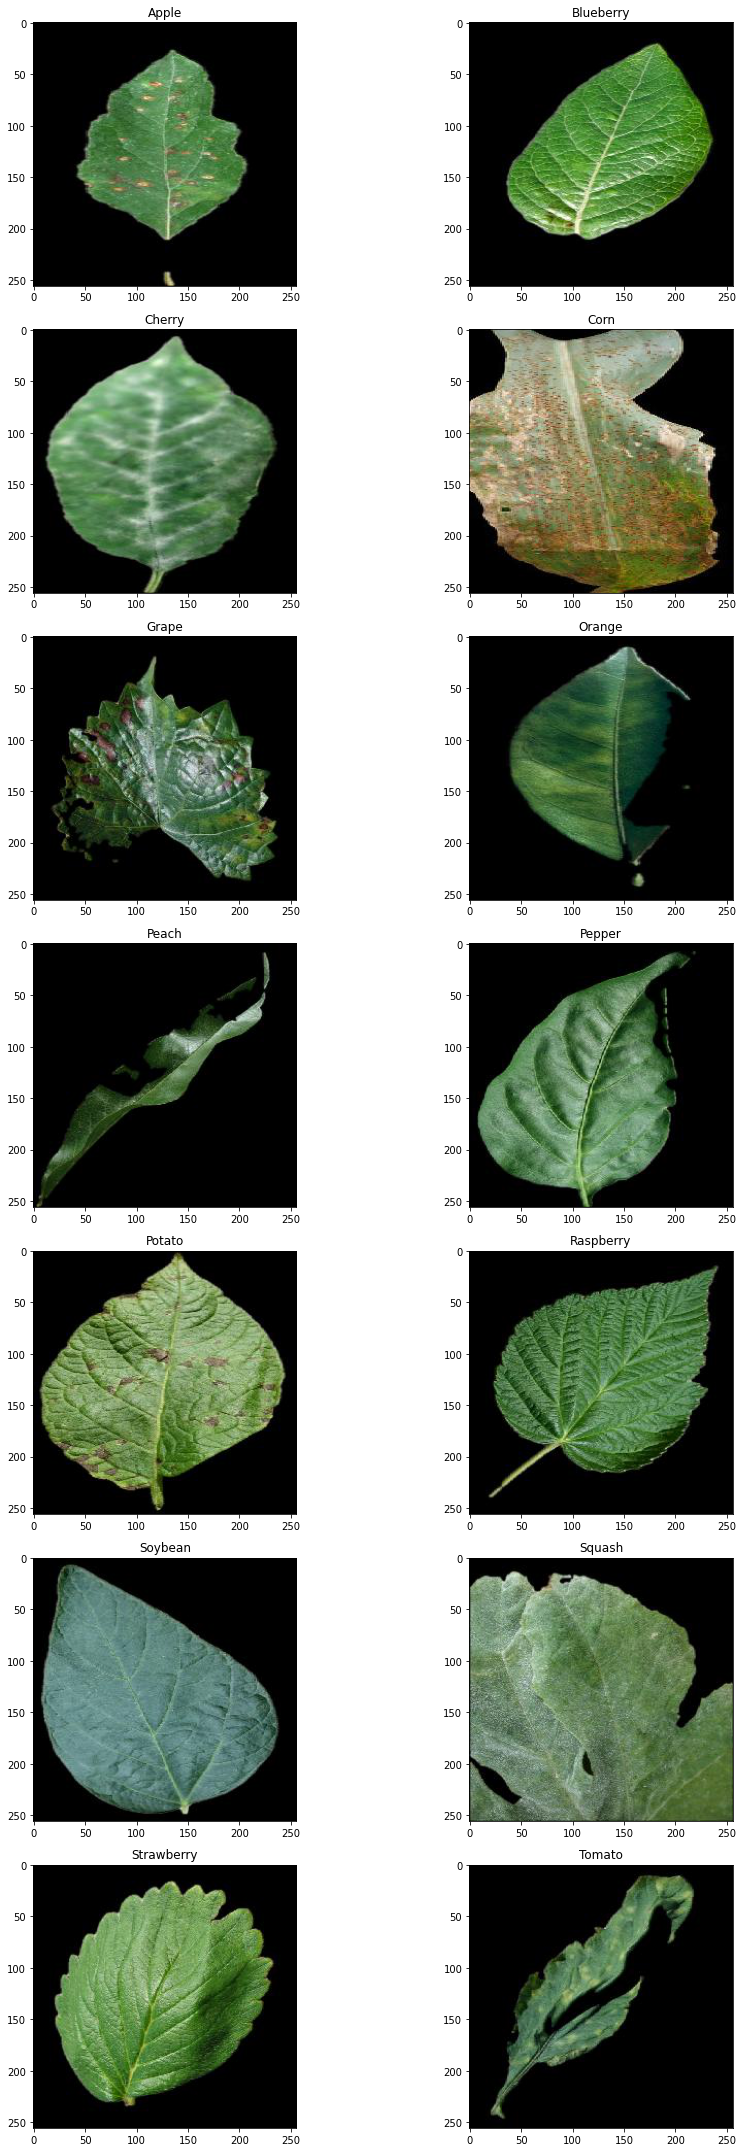

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [ ]:
# Inspect dataset structure on disk
print("Depth 0 (leaves_test_overUnder_sampled)")
print("-------")
!ls leaves_test_overUnder_sampled
print()
print("Depth 1 (e.g., leaves_test_overUnder_sampled/training)")
print("------------------------")
!ls leaves_test_overUnder_sampled/train
print()
print("Depth 2 (e.g., leaves_test_overUnder_sampled/training/Blueberry)")
print("----------------------------")
!ls leaves_test_overUnder_sampled/train/Blueberry

Depth 0 (leaves_test_overUnder_sampled)
-------
test  train  val

Depth 1 (e.g., leaves_test_overUnder_sampled/training)
------------------------
Apple	   Cherry  Grape   Peach   Potato     Soybean  Strawberry
Blueberry  Corn    Orange  Pepper  Raspberry  Squash   Tomato

Depth 2 (e.g., leaves_test_overUnder_sampled/training/Blueberry)
----------------------------
0_01840.jpg  01827.jpg	02005.jpg  02190.jpg		180_02029.jpg
01647.jpg    01828.jpg	02006.jpg  02191.jpg		18_01953.jpg
01649.jpg    01829.jpg	02007.jpg  02193.jpg		181_01653.jpg
01650.jpg    01830.jpg	02008.jpg  02195.jpg		182_14_01953.jpg
01652.jpg    01831.jpg	02009.jpg  02196.jpg		183_02081.jpg
01653.jpg    01832.jpg	02012.jpg  02197.jpg		184_01996.jpg
01654.jpg    01833.jpg	02014.jpg  02198.jpg		185_01973.jpg
01655.jpg    01835.jpg	02015.jpg  02199.jpg		186_01890.jpg
01656.jpg    01837.jpg	02019.jpg  02203.jpg		187_125_02212.jpg
01657.jpg    01838.jpg	02022.jpg  02205.jpg		188_02127.jpg
01658.jpg    01840.jpg	02023.jpg  022

#Data Generator

Import:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from random import randint

Defining a pre processing function which changes the color of the background randomly.

In [ ]:
def change_background(image):
    image = np.array(image)
    h = random.random()
    if h > 0.33 and h<0.66:
      image[image[:, :, 0] <= 10] = 255 # set bg to white
    elif h >0.66:
      image[image[:, :, 0] <= 10] = 189 # set bg to grey
    return image

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=70,
                                        width_shift_range=120,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='constant',
                                        cval=0,
                                        preprocessing_function=change_background, #Makes our custom function to be called during data augmentation
                                        rescale=1/255.)
aug_valid_data_gen = ImageDataGenerator(rotation_range=180, # --- N.B. --- While trying to increase performances, we tried to perform data augmentation also here, because in some classes, like the raspberry one, when we oversampled the validation set, it contained many copies. Doing some researches, we found online that, sometimes, in some specific applications, this helped a little bit and we wanted to try
                                        height_shift_range=70,
                                        width_shift_range=120,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='constant',
                                        cval=0,
                                        rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.) #to be commented if used with dataset "_notest" (not recommended)





# class_mode parameter not inserted: cathegorical (one hot coding) is the default one, hence, it is not necessary
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

aug_valid_gen = aug_valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

test_gen = test_data_gen.flow_from_directory(directory=test_dir,         #to be commented if used with dataset "_notest" (not recommended)
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=None,
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 7700 images belonging to 14 classes.
Found 3500 images belonging to 14 classes.
Found 1785 images belonging to 14 classes.


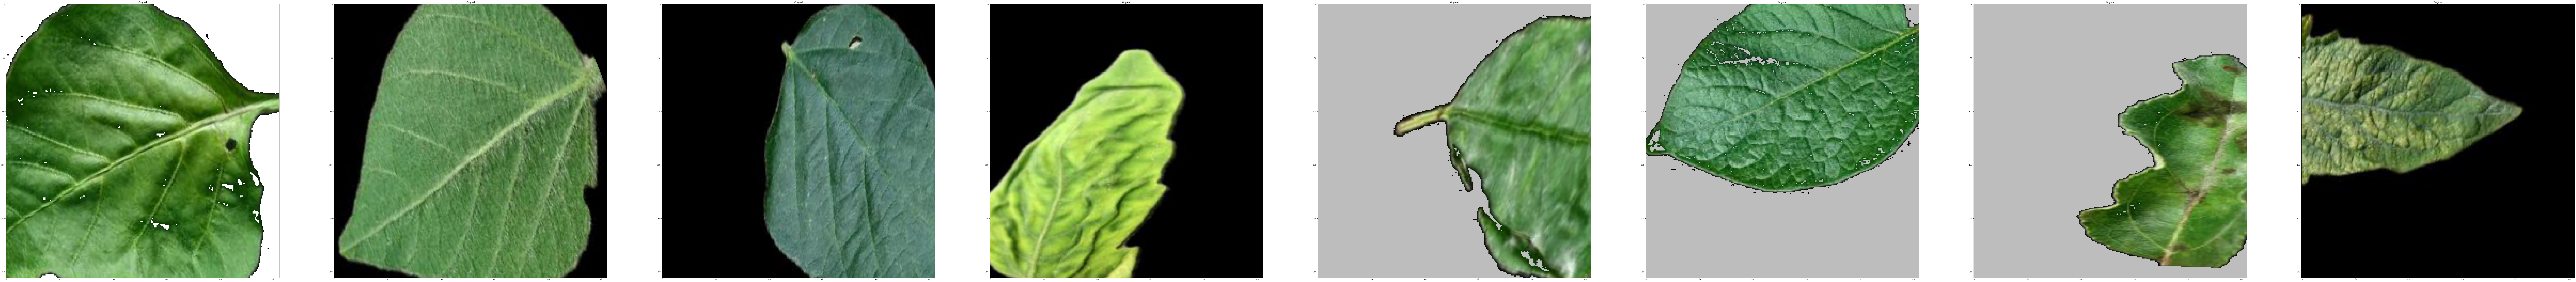

In [ ]:
image = next(aug_train_gen)[0]

fig, ax = plt.subplots(1, 8, figsize=(255, 255))
init = 0
for i in range(init, init+8):
  #print(image[i])
  ax[i-init].imshow(np.array(image[i]))
  ax[i-init].set_title('Original')

#Characteristics

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

#Declaring Network

Let's work first with the network, and then declaring callbacks and checkpoints

In [ ]:
# Model used:
# (Conv + ReLU + MaxPool) x 5 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.AveragePooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.AveragePooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.AveragePooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.AveragePooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.AveragePooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics='accuracy')

    # Return the model
    return model

Function which creates folders for callbacks

In [ ]:
from datetime import datetime

def create_folders_and_callbacks(model_name):
  #saving checkpoints on drive. We need to change directory, hence, we need ../ to go back of on folder, from /content to /
  #N.B.: after this we don't need to go back, we did not change directory, we worked with the string of the path
  exps_dir = os.path.join('../gdrive/MyDrive/AN2DL/Checkpts/LucaA') #this is the directory in which will be saved all checkpoints of LucaA of all experiments
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now)) #here will be saved the checkpoints of this single experiment
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = [] #declare a list of empty callbacks

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts') #In the directory of the experiment will be created the directory ckpts
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

#Building Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 average_pooling2d (AverageP  (None, 128, 128, 16)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 64, 64, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496 

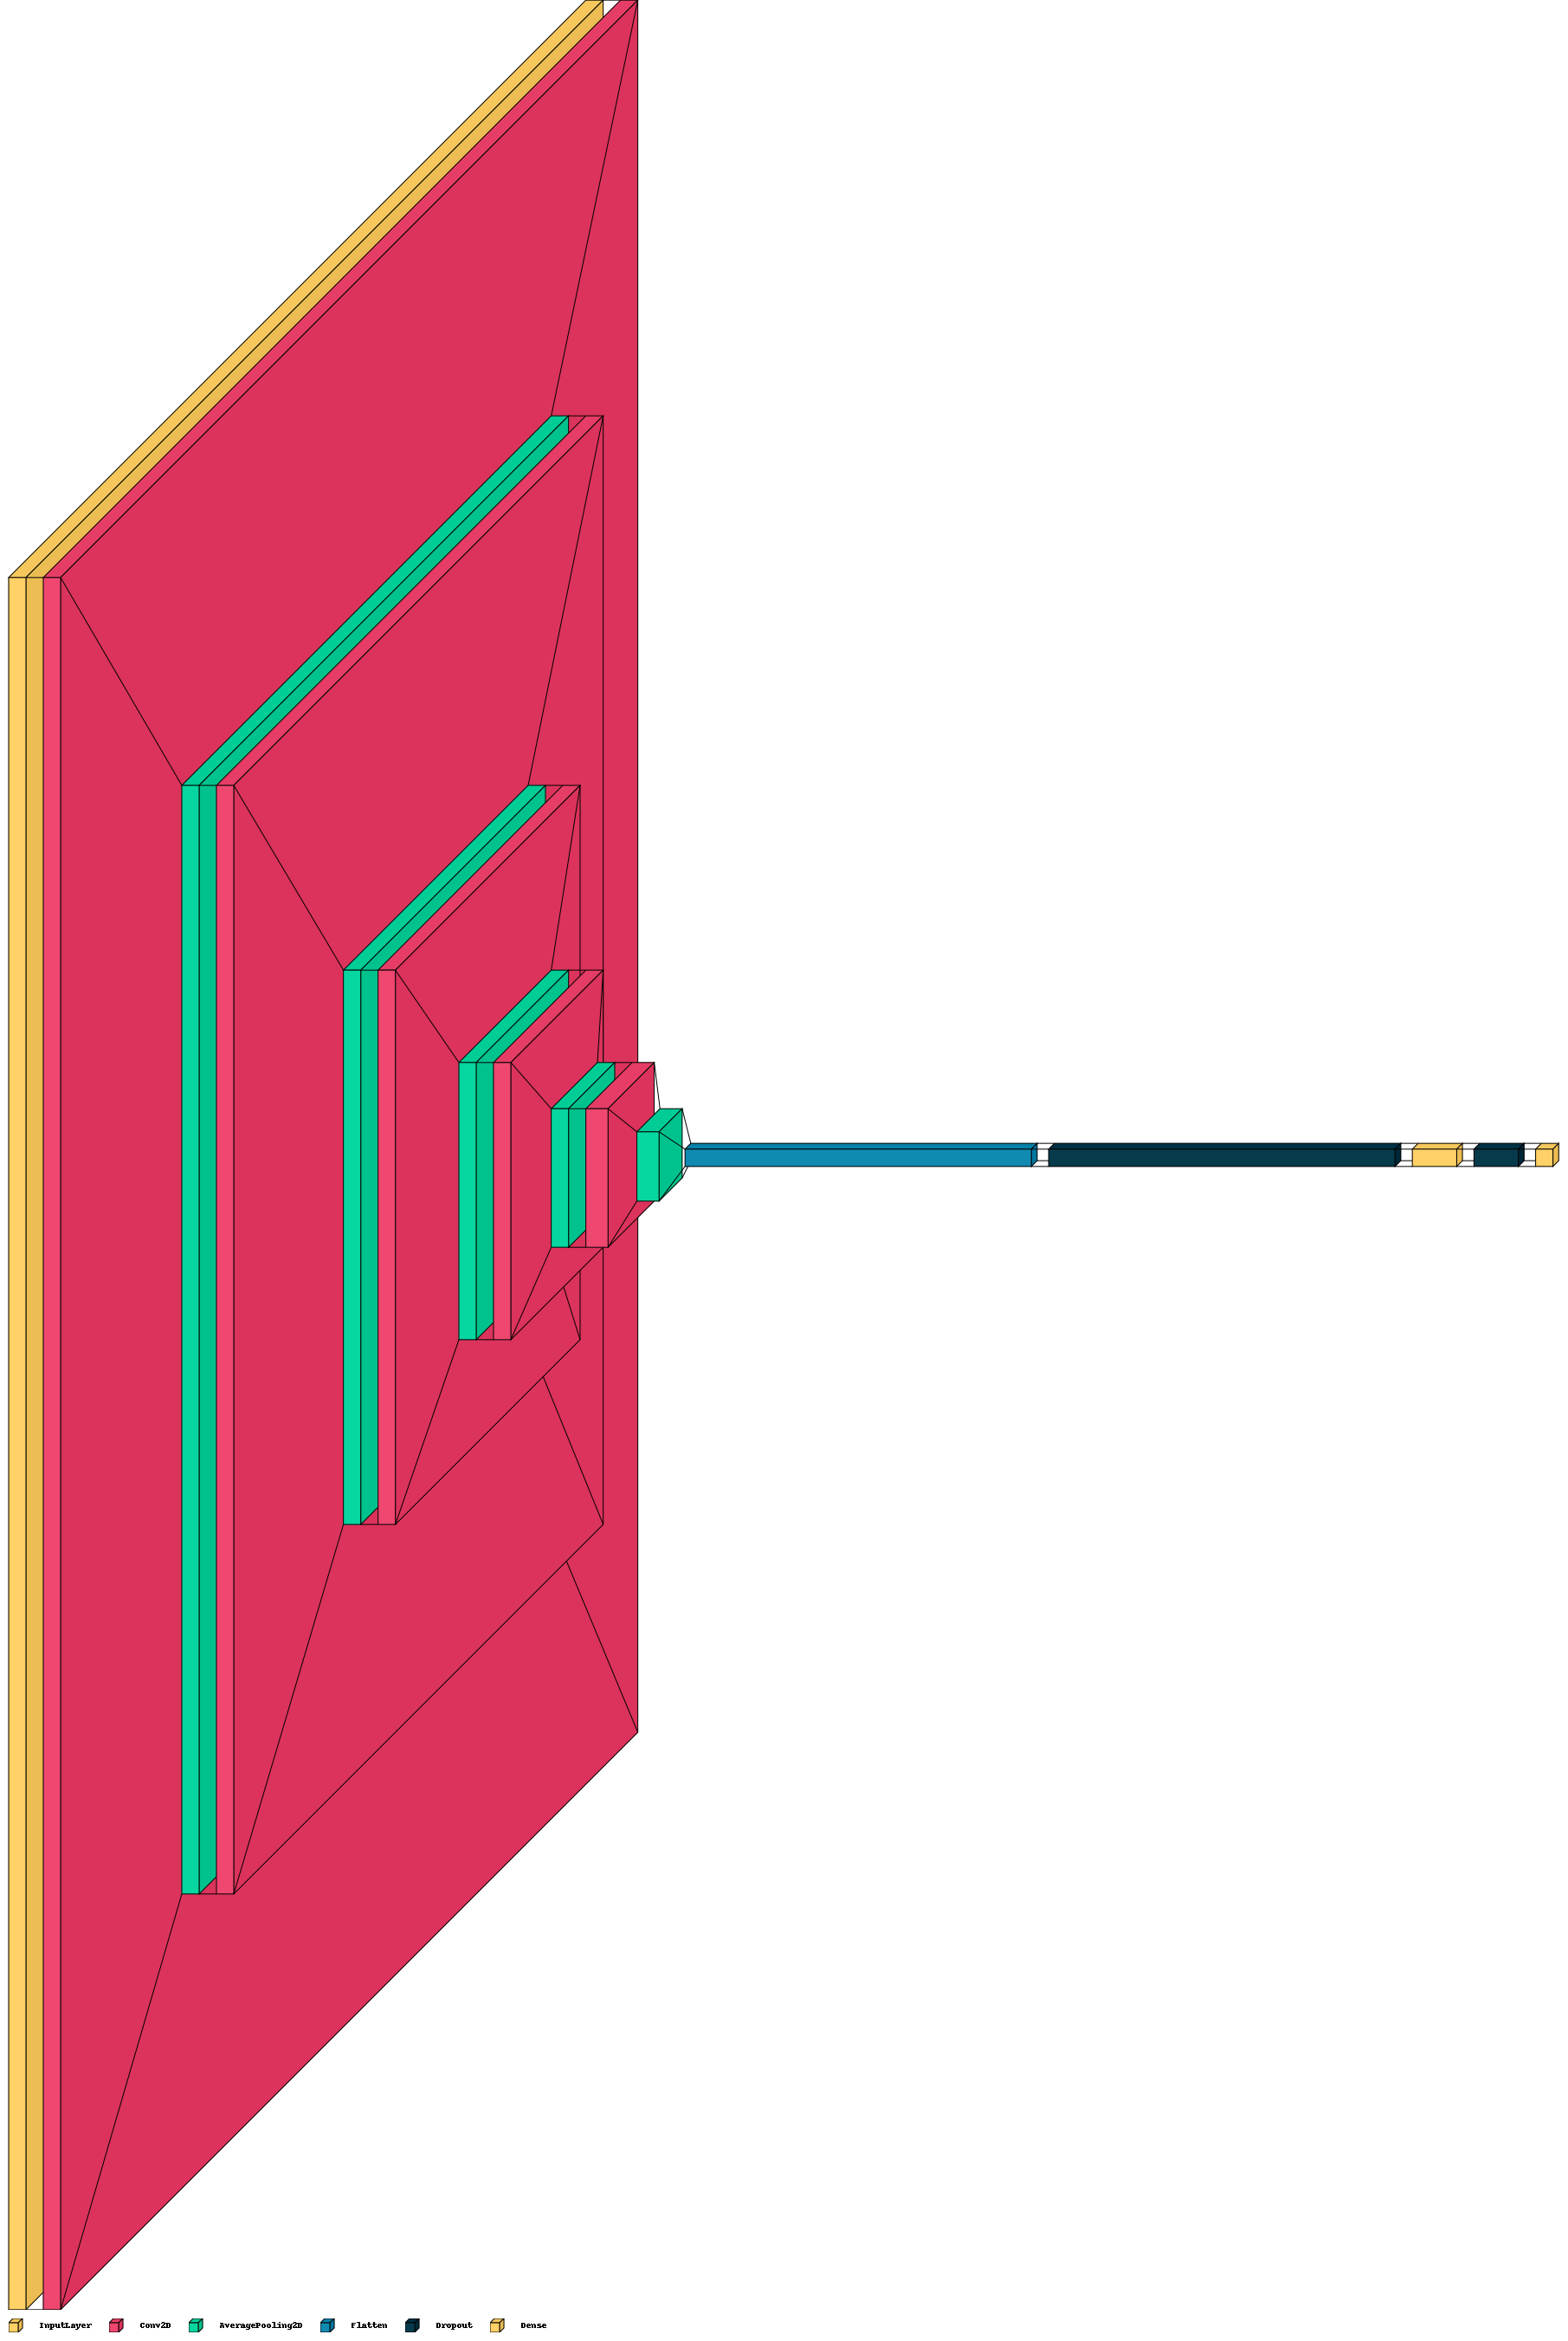

In [ ]:
# Build model
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

#Training the model

In [ ]:
# Create folders and callbacks and fit
aug_bal_callbacks = create_folders_and_callbacks(model_name = 'aug_balanced_LowLearning_ChangeColor_MorePatience_avg') #the model name will generate the folder of this single experiment

# restore checkpoints: (uncomment if needed)
#model.load_weights('/gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_08-40-12/ckpts/cp.ckpt') #for this, I've looked at: https://www.tensorflow.org/tutorials/keras/save_and_load
#In this way, the training will restart from that specific checkpoint: clearly, Epoch number will restart from zero, but that's not a problem, it's restarting from the weights computed at ckpt

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = aug_valid_gen,
    callbacks = aug_bal_callbacks,
).history

Epoch 1/200
963/963 [==============================] - ETA: 0s - loss: 0.2412 - accuracy: 0.9231

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 177s 166ms/step - loss: 0.2412 - accuracy: 0.9231 - val_loss: 0.3205 - val_accuracy: 0.8983
Epoch 2/200
963/963 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.9200

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 159s 166ms/step - loss: 0.2376 - accuracy: 0.9200 - val_loss: 0.2921 - val_accuracy: 0.9060
Epoch 3/200
963/963 [==============================] - ETA: 0s - loss: 0.2314 - accuracy: 0.9256

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 159s 166ms/step - loss: 0.2314 - accuracy: 0.9256 - val_loss: 0.2745 - val_accuracy: 0.9123
Epoch 4/200
963/963 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.9230

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 161s 167ms/step - loss: 0.2287 - accuracy: 0.9230 - val_loss: 0.2435 - val_accuracy: 0.9237
Epoch 5/200
963/963 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.9226

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 161s 167ms/step - loss: 0.2287 - accuracy: 0.9226 - val_loss: 0.2644 - val_accuracy: 0.9129
Epoch 6/200
963/963 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9352

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 161s 167ms/step - loss: 0.2053 - accuracy: 0.9352 - val_loss: 0.2803 - val_accuracy: 0.9157
Epoch 7/200
963/963 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9271

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 160s 166ms/step - loss: 0.2133 - accuracy: 0.9271 - val_loss: 0.2428 - val_accuracy: 0.9186
Epoch 8/200
963/963 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.9286

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 156s 162ms/step - loss: 0.2227 - accuracy: 0.9286 - val_loss: 0.3781 - val_accuracy: 0.8826
Epoch 9/200
963/963 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9300

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 158s 164ms/step - loss: 0.2113 - accuracy: 0.9300 - val_loss: 0.2680 - val_accuracy: 0.9206
Epoch 10/200
963/963 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9332

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 160s 166ms/step - loss: 0.1969 - accuracy: 0.9332 - val_loss: 0.2319 - val_accuracy: 0.9289
Epoch 11/200
963/963 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9316

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 199s 207ms/step - loss: 0.2024 - accuracy: 0.9316 - val_loss: 0.2559 - val_accuracy: 0.9169
Epoch 12/200
963/963 [==============================] - ETA: 0s - loss: 0.2041 - accuracy: 0.9319

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 158s 164ms/step - loss: 0.2041 - accuracy: 0.9319 - val_loss: 0.3375 - val_accuracy: 0.8917
Epoch 13/200
963/963 [==============================] - ETA: 0s - loss: 0.2061 - accuracy: 0.9338

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 158s 164ms/step - loss: 0.2061 - accuracy: 0.9338 - val_loss: 0.2433 - val_accuracy: 0.9217
Epoch 14/200
963/963 [==============================] - ETA: 0s - loss: 0.1927 - accuracy: 0.9357

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 158s 164ms/step - loss: 0.1927 - accuracy: 0.9357 - val_loss: 0.2830 - val_accuracy: 0.9037
Epoch 15/200
963/963 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.9371

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 157s 163ms/step - loss: 0.1881 - accuracy: 0.9371 - val_loss: 0.2659 - val_accuracy: 0.9231
Epoch 16/200
963/963 [==============================] - ETA: 0s - loss: 0.1935 - accuracy: 0.9349

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 157s 163ms/step - loss: 0.1935 - accuracy: 0.9349 - val_loss: 0.3659 - val_accuracy: 0.8889
Epoch 17/200
963/963 [==============================] - ETA: 0s - loss: 0.1799 - accuracy: 0.9403

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 157s 164ms/step - loss: 0.1799 - accuracy: 0.9403 - val_loss: 0.2743 - val_accuracy: 0.9166
Epoch 18/200
963/963 [==============================] - ETA: 0s - loss: 0.1810 - accuracy: 0.9409

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 162s 168ms/step - loss: 0.1810 - accuracy: 0.9409 - val_loss: 0.2209 - val_accuracy: 0.9289
Epoch 19/200
963/963 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.9400

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 159s 165ms/step - loss: 0.1777 - accuracy: 0.9400 - val_loss: 0.2538 - val_accuracy: 0.9171
Epoch 20/200
963/963 [==============================] - ETA: 0s - loss: 0.1758 - accuracy: 0.9399

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 162s 168ms/step - loss: 0.1758 - accuracy: 0.9399 - val_loss: 0.2757 - val_accuracy: 0.9171
Epoch 21/200
963/963 [==============================] - ETA: 0s - loss: 0.1845 - accuracy: 0.9408

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 164s 171ms/step - loss: 0.1845 - accuracy: 0.9408 - val_loss: 0.2190 - val_accuracy: 0.9283
Epoch 22/200
963/963 [==============================] - ETA: 0s - loss: 0.1671 - accuracy: 0.9456

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 162s 168ms/step - loss: 0.1671 - accuracy: 0.9456 - val_loss: 0.3312 - val_accuracy: 0.8971
Epoch 23/200
963/963 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9438

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 162s 168ms/step - loss: 0.1681 - accuracy: 0.9438 - val_loss: 0.2429 - val_accuracy: 0.9203
Epoch 24/200
963/963 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.9417

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 162s 168ms/step - loss: 0.1673 - accuracy: 0.9417 - val_loss: 0.2361 - val_accuracy: 0.9274
Epoch 25/200
963/963 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9496

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 162s 169ms/step - loss: 0.1604 - accuracy: 0.9496 - val_loss: 0.2199 - val_accuracy: 0.9294
Epoch 26/200
963/963 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9465

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 162s 169ms/step - loss: 0.1547 - accuracy: 0.9465 - val_loss: 0.2515 - val_accuracy: 0.9283
Epoch 27/200
963/963 [==============================] - ETA: 0s - loss: 0.1687 - accuracy: 0.9436

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 162s 169ms/step - loss: 0.1687 - accuracy: 0.9436 - val_loss: 0.2192 - val_accuracy: 0.9349
Epoch 28/200
963/963 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9449

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 170ms/step - loss: 0.1550 - accuracy: 0.9449 - val_loss: 0.2311 - val_accuracy: 0.9263
Epoch 29/200
963/963 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.9439

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 169ms/step - loss: 0.1617 - accuracy: 0.9439 - val_loss: 0.3368 - val_accuracy: 0.9011
Epoch 30/200
963/963 [==============================] - ETA: 0s - loss: 0.1488 - accuracy: 0.9497

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 169ms/step - loss: 0.1488 - accuracy: 0.9497 - val_loss: 0.3104 - val_accuracy: 0.9083
Epoch 31/200
963/963 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.9491

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 170ms/step - loss: 0.1529 - accuracy: 0.9491 - val_loss: 0.2098 - val_accuracy: 0.9354
Epoch 32/200
963/963 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9488

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 169ms/step - loss: 0.1501 - accuracy: 0.9488 - val_loss: 0.2160 - val_accuracy: 0.9343
Epoch 33/200
963/963 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9508

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 169ms/step - loss: 0.1501 - accuracy: 0.9508 - val_loss: 0.2247 - val_accuracy: 0.9323
Epoch 34/200
963/963 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.9513

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 169ms/step - loss: 0.1406 - accuracy: 0.9513 - val_loss: 0.2317 - val_accuracy: 0.9223
Epoch 35/200
963/963 [==============================] - ETA: 0s - loss: 0.1458 - accuracy: 0.9516

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 170ms/step - loss: 0.1458 - accuracy: 0.9516 - val_loss: 0.1960 - val_accuracy: 0.9403
Epoch 36/200
963/963 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9523

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 164s 170ms/step - loss: 0.1414 - accuracy: 0.9523 - val_loss: 0.1760 - val_accuracy: 0.9406
Epoch 37/200
963/963 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.9547

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 164s 170ms/step - loss: 0.1332 - accuracy: 0.9547 - val_loss: 0.2419 - val_accuracy: 0.9274
Epoch 38/200
963/963 [==============================] - ETA: 0s - loss: 0.1392 - accuracy: 0.9555

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 169ms/step - loss: 0.1392 - accuracy: 0.9555 - val_loss: 0.1872 - val_accuracy: 0.9463
Epoch 39/200
963/963 [==============================] - ETA: 0s - loss: 0.1410 - accuracy: 0.9535

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 169ms/step - loss: 0.1410 - accuracy: 0.9535 - val_loss: 0.2208 - val_accuracy: 0.9337
Epoch 40/200
963/963 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9540

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 170ms/step - loss: 0.1409 - accuracy: 0.9540 - val_loss: 0.2006 - val_accuracy: 0.9423
Epoch 41/200
963/963 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9568

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 162s 169ms/step - loss: 0.1308 - accuracy: 0.9568 - val_loss: 0.2421 - val_accuracy: 0.9306
Epoch 42/200
963/963 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9558

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 162s 168ms/step - loss: 0.1329 - accuracy: 0.9558 - val_loss: 0.2204 - val_accuracy: 0.9343
Epoch 43/200
963/963 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.9586

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 162s 169ms/step - loss: 0.1291 - accuracy: 0.9586 - val_loss: 0.2935 - val_accuracy: 0.9140
Epoch 44/200
963/963 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9569

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 169ms/step - loss: 0.1334 - accuracy: 0.9569 - val_loss: 0.2607 - val_accuracy: 0.9157
Epoch 45/200
963/963 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9584

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 169ms/step - loss: 0.1232 - accuracy: 0.9584 - val_loss: 0.2463 - val_accuracy: 0.9277
Epoch 46/200
963/963 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9581

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 169ms/step - loss: 0.1272 - accuracy: 0.9581 - val_loss: 0.2417 - val_accuracy: 0.9263
Epoch 47/200
963/963 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9570

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 169ms/step - loss: 0.1264 - accuracy: 0.9570 - val_loss: 0.2927 - val_accuracy: 0.9180
Epoch 48/200
963/963 [==============================] - ETA: 0s - loss: 0.1221 - accuracy: 0.9613

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 169ms/step - loss: 0.1221 - accuracy: 0.9613 - val_loss: 0.2462 - val_accuracy: 0.9291
Epoch 49/200
963/963 [==============================] - ETA: 0s - loss: 0.1269 - accuracy: 0.9579

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 162s 168ms/step - loss: 0.1269 - accuracy: 0.9579 - val_loss: 0.2323 - val_accuracy: 0.9306
Epoch 50/200
963/963 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9599

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 163s 170ms/step - loss: 0.1215 - accuracy: 0.9599 - val_loss: 0.2426 - val_accuracy: 0.9294
Epoch 51/200
963/963 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9608

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 161s 167ms/step - loss: 0.1190 - accuracy: 0.9608 - val_loss: 0.2394 - val_accuracy: 0.9337
Epoch 52/200
963/963 [==============================] - ETA: 0s - loss: 0.1315 - accuracy: 0.9582

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 158s 165ms/step - loss: 0.1315 - accuracy: 0.9582 - val_loss: 0.2910 - val_accuracy: 0.9206
Epoch 53/200
963/963 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9616

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 159s 166ms/step - loss: 0.1227 - accuracy: 0.9616 - val_loss: 0.2324 - val_accuracy: 0.9300
Epoch 54/200
963/963 [==============================] - ETA: 0s - loss: 0.1091 - accuracy: 0.9653

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 159s 165ms/step - loss: 0.1091 - accuracy: 0.9653 - val_loss: 0.2222 - val_accuracy: 0.9357
Epoch 55/200
963/963 [==============================] - ETA: 0s - loss: 0.1125 - accuracy: 0.9608

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 158s 164ms/step - loss: 0.1125 - accuracy: 0.9608 - val_loss: 0.2118 - val_accuracy: 0.9343
Epoch 56/200
963/963 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.9606

INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


INFO:tensorflow:Assets written to: ../gdrive/MyDrive/AN2DL/Checkpts/LucaA/aug_balanced_LowLearning_ChangeColor_MorePatience_avg_Nov22_17-55-30/ckpts/cp.ckpt/assets


963/963 [==============================] - 159s 165ms/step - loss: 0.1228 - accuracy: 0.9606 - val_loss: 0.1966 - val_accuracy: 0.9437


#Saving the model

In [ ]:
%cd /gdrive/MyDrive/AN2DL/models

/gdrive/MyDrive/AN2DL/models


In [ ]:
# Save best epoch model
model.save("Models/LucaA/Augmented_Balanced_LowLearning_ChangeColor_MorePatience_avg")

INFO:tensorflow:Assets written to: Models/LucaA/Augmented_Balanced_LowLearning_ChangeColor_MorePatience_avg/assets


INFO:tensorflow:Assets written to: Models/LucaA/Augmented_Balanced_LowLearning_ChangeColor_MorePatience_avg/assets


#Plot training error and validation error

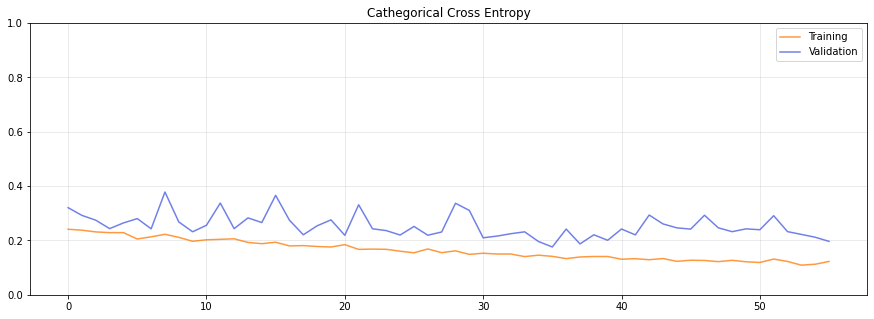

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2') # "Val because it is on validation set"
plt.ylim(0, 1)
plt.title('Cathegorical Cross Entropy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

#Testing
N.B.: this cells can be executed only if considering the dataset with the test folder (reccommend to use the dataset with the test folder)

In [ ]:
cd /content

/content


In [ ]:
model_to_be_tested = tfk.models.load_model("../gdrive/MyDrive/AN2DL/models/Models/LucaA/Augmented_Balanced_LowLearning_ChangeColor_MorePatience_avg")
model_to_be_tested_metrics = model_to_be_tested.evaluate(test_gen, return_dict=True)

224/224 [==============================] - 5s 21ms/step - loss: 0.2806 - accuracy: 0.9227


#Further informations on testing

##Printing Activations

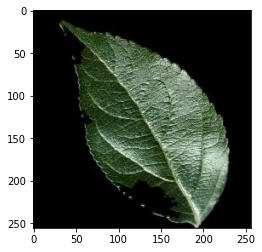

In [ ]:
# Get sample batch
batch = next(test_gen)[0]

# Get first image
image = batch[3] # batch size = 8

fig = plt.figure(figsize=(6, 4))
plt.imshow(np.uint8(image*255))

In [ ]:
# Get the activations (the output of each ReLU layer)
# We can do it by creating a new Model (activation_model) with the same input as 
# the original model and all the ReLU activations as output
layers = [layer.output for layer in model_to_be_tested.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = tf.keras.Model(inputs=model_to_be_tested.input, outputs=layers)
# Finally we get the output feature maps (for each layer) given the imput test image
fmaps = activation_model.predict(tf.expand_dims(image, 0))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
def display_activation(fmaps, depth=0, first_n=-1): 
    # fmaps: list of all the feature maps for each layer
    # depth: the layer we want to visualize (an int in [0, network depth))
    # first_n: default '-1' means 'all activations'. Number of activations to be visualized. Note that for deep layers it could be a large number.

    fmaps = fmaps[depth] # get feature maps at the desired depth
    if first_n > 0:
      fmaps = fmaps[0, :, :, :first_n] 
    fmaps = tf.image.resize(fmaps, size=[128, 128]) # resize for visualization

    # Distribute on a grid for plotting
    col_size = 8
    row_size = fmaps.shape[-1] // 8
    fmap_channel=0
    fig = plt.figure(figsize=(30, 30))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(row_size, col_size),  
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for row in range(0,row_size):
        for col in range(0,col_size):
            grid[fmap_channel].imshow(fmaps[0, :, :, fmap_channel], cmap='gray', aspect='auto')
            fmap_channel += 1
    plt.show()

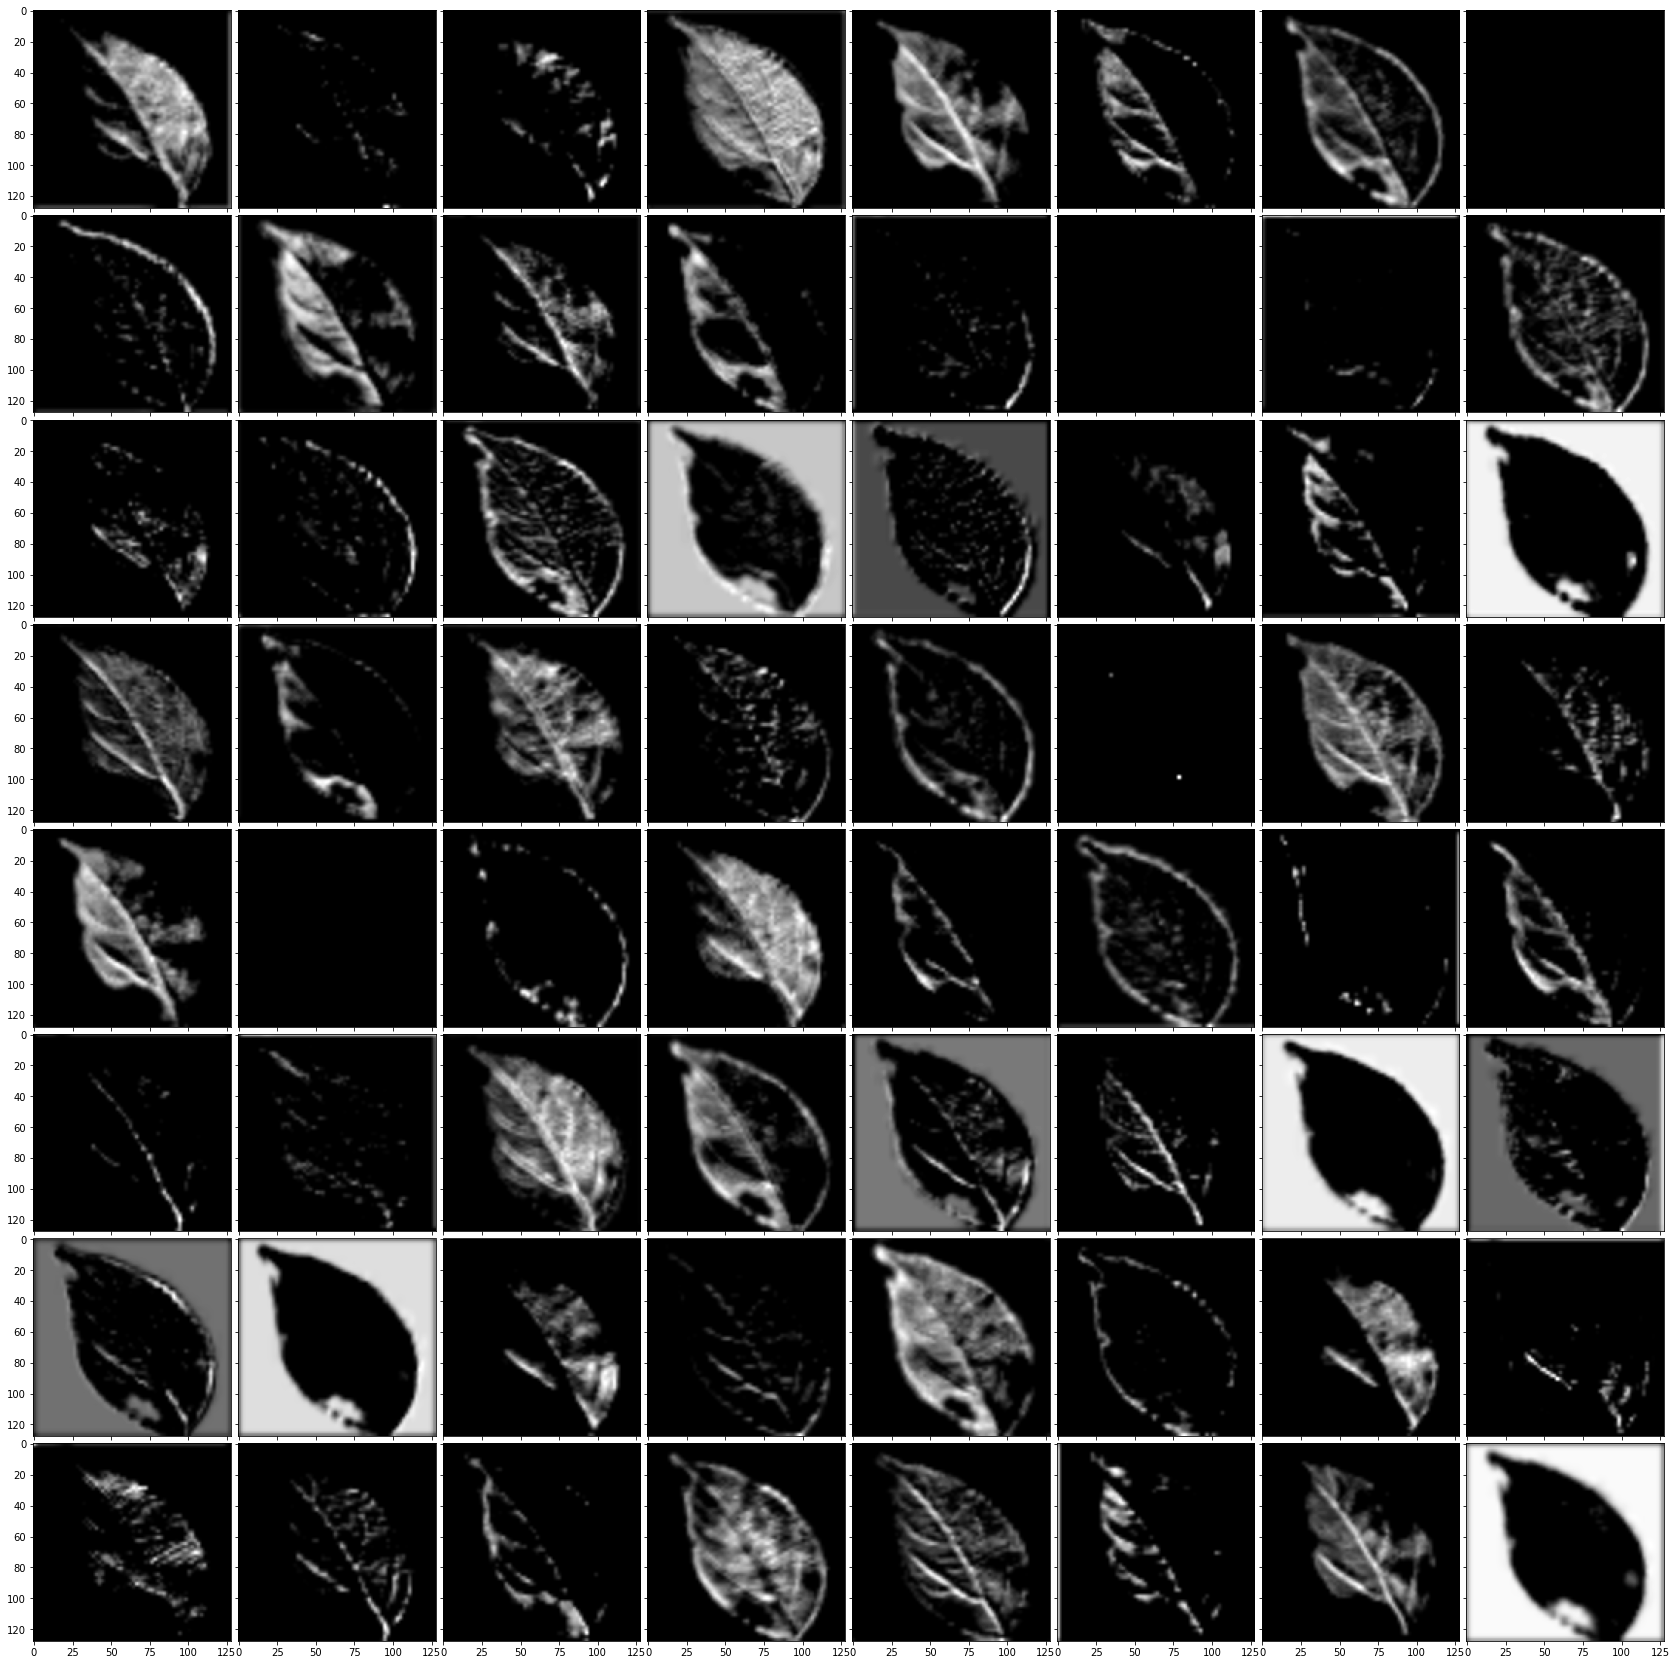

In [ ]:
display_activation(fmaps=fmaps, depth=2, first_n=-1)

##Confusion Matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Accuracy: 0.9227
Precision: 0.9052
Recall: 0.9509
F1: 0.923


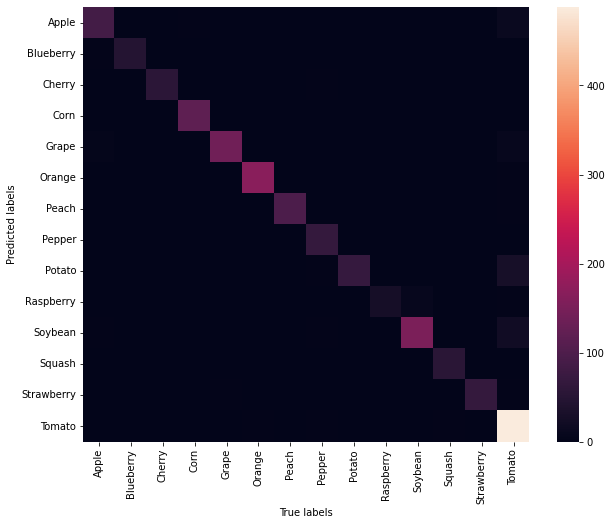

In [ ]:
predictions = model_to_be_tested.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()